# Tutorial on how to measure DIBs in cool stellar spectra of LAMOST LRS

This demo Jupyter notebook can be downloaded at [GitHub](https://github.com/iScottMark/LAMOST_DIB/tutorials/).

The key step of measurement of DIBs in stellar spectra is NOT the measurement itself, but the extraction of the interstellar medium (ISM) spectrum from the stellar spectrum. Because the ISM absorption lines, e.g., DIBs, Na I, Ca II, etc., are often blended with the stellar absorption lines, we need to remove the stellar contribution first.

Refer to the paper by [Ma et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024A%26A...691A.282M/abstract) for more details on the method.

In [1]:
# import some necessary modules
import os
import sys
from pathlib import Path

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

# import self-defined modules `dibkit`
sys.path.append('../')
from dibkit.core import utils, sample, neighbor, cis
from dibkit.dib import measure, tools_5780

## Step.1: Build target and reference catalogs

In [2]:
# Build target catalog and reference catalogs from the LAMOST catalog `cool_lamost_with_Gaia_ebv.fits`
# This processing needs a lot of memory and a few minutes
# The filtering is encapsulated in `dib.core.sample.load_catalog()`
# If needed, you can step into that function to see how the filtering is done.
df_reference, df_target = sample.load_catalog()

Loading catalog from /home/maxiaoxiao/LAMOST_DIB/inputs/cool_lamost_with_Gaia_ebv.fits...
Catalog loaded successfully.
(7297243, 45)


## Step.2: Load a cool stellar spectrum

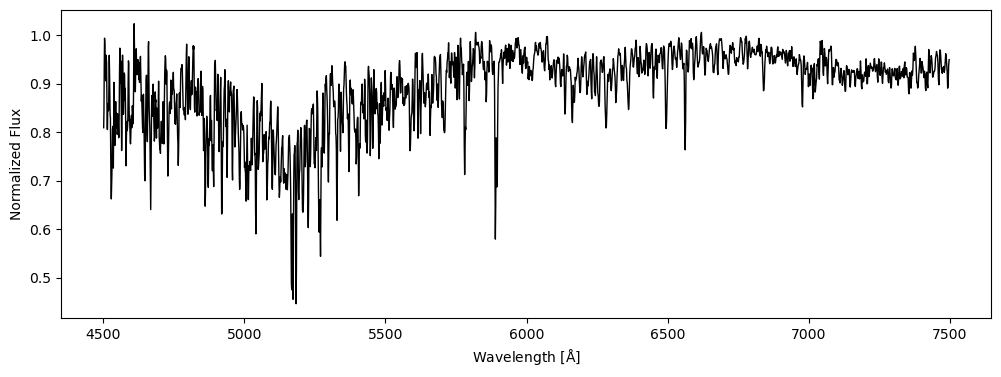

In [3]:
# Select a demo star according to the unique spectra identifier in LAMOST, namely, `obsid`
obsid = 837603202
target_info = df_target[df_target['obsid'] == obsid].iloc[0]

# Read the spctrum
ROOT = '../'
abs_spec_path = utils.get_spec_path(target_info, os.path.join(ROOT, 'datasets/demo_lamost_lrs_dr10_v1.0'))
wave_vac, flux, flux_norm, ivar = utils.read_fits(abs_spec_path)
# transform from vacuum to air
wave_air = utils.vac2air(wave_vac)
# truncate to the range of 4500 to 7500
idx = (wave_air >= 4500) & (wave_air <= 7500)
wave_air = wave_air[idx]
flux_norm = flux_norm[idx]

# Plot the spectrum
plt.figure(figsize=(12, 4))
plt.plot(wave_air, flux_norm, c='k', lw=1)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.show()

## Step.3: Get ISM residual spectra from the target spectrum

### 3.1. Match the neighboring spectra of the target spectrum from the reference catalog

The number of matched reference spectra: 660



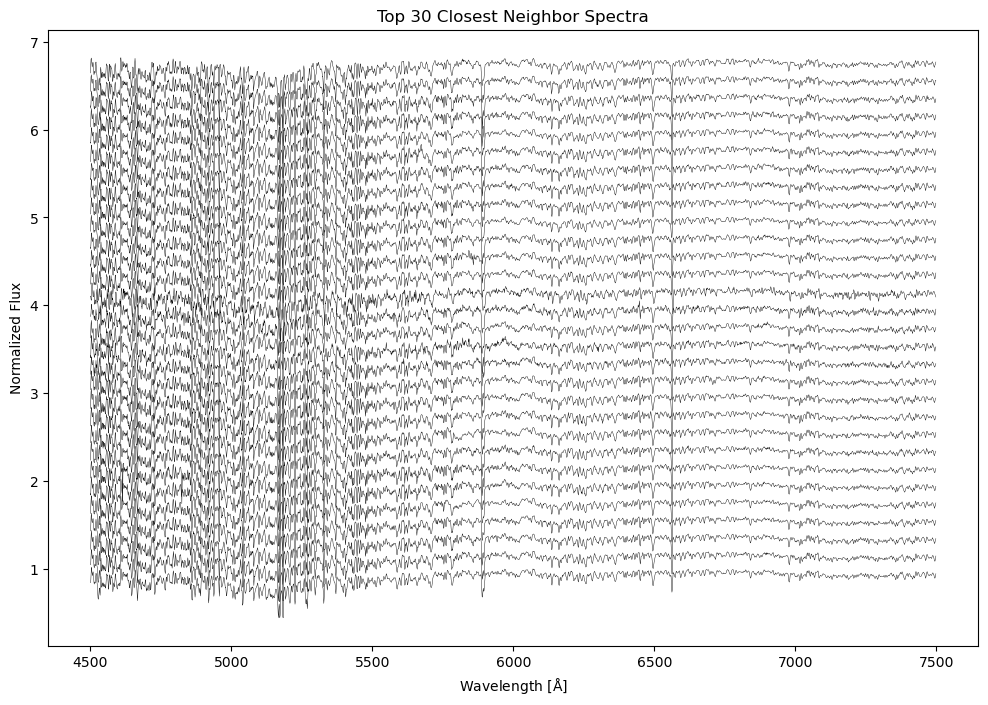

In [4]:
# Instantiate the class `Neighbor`
neighbors = neighbor.Neighbor(df_reference)
neighbors.set_target(target_info)

# Find the nearest neighbors in the reference catalog
n_match = neighbors.n_match
print(f'The number of matched reference spectra: {n_match}\n')
df_closest_neighbor = neighbors.closest_neighbor_info

# Plot the top 30 closest neighbor spectra
plt.figure(figsize=(12, 8))
offset = 0.0
for i in range(30):
    neighbor_info = df_closest_neighbor.iloc[i]
    abs_spec_path = utils.get_spec_path(neighbor_info, os.path.join(ROOT, 'datasets/demo_lamost_lrs_dr10_v1.0'))
    wave_vac, flux, flux_norm, ivar = utils.read_fits(abs_spec_path)
    wave_air = utils.vac2air(wave_vac)
    idx = (wave_air >= 4500) & (wave_air <= 7500)
    wave_air = wave_air[idx]
    flux_norm = flux_norm[idx]
    plt.plot(wave_air, flux_norm+offset, c='k', lw=-.3, label=f'{i+1}th closest neighbor')
    offset += 0.2

plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.title('Top 30 Closest Neighbor Spectra')
plt.show()

### 3.2. Combined the neighboring spectra to get the template spectrum within the DIB region

/home/maxiaoxiao/LAMOST_DIB/tutorials/../dibkit/core/spec.py:149: RuntimeWarning: divide by zero encountered in divide
  err_flux_norm = 1 / np.sqrt(ivar_norm)


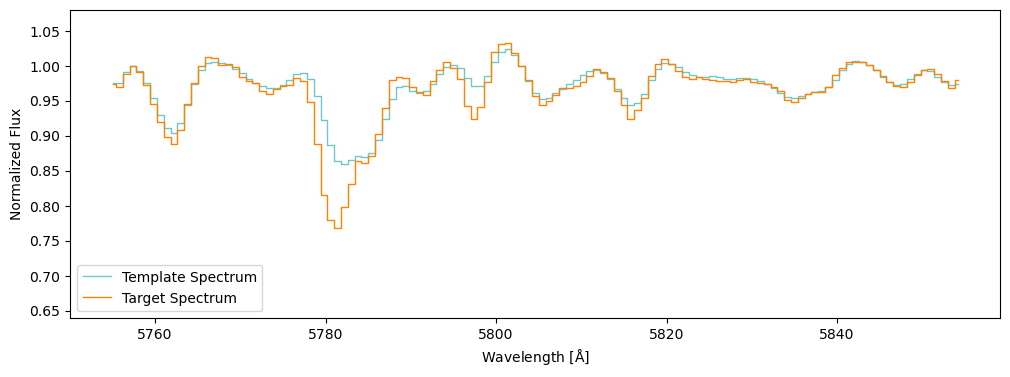

In [5]:
# Instantiate the class `CIS`
# The DIB region is defined by the wavelength range and step size
# This dictionary can be loaded from ``../configs/dib.yml`
dib_region_dict = {
    'xmin': 5755, 
    'xmax': 5855,
    'step': 0.8
}
cis_target = cis.CIS(
    dib_region=dib_region_dict, 
    target_info=target_info, 
    closest_neighbor_info=df_closest_neighbor
    )

dib_region = np.arange(dib_region_dict['xmin'], dib_region_dict['xmax'], dib_region_dict['step'])
flux_template = cis_target.flux_template
flux_target = cis_target.flux_target

# Plot the target spectrum and the template spectrum within the DIB region
plt.figure(figsize=(12, 4))
plt.step(dib_region, flux_template, c='#6EC8C8', lw=1, where='mid', label='Template Spectrum')
plt.step(dib_region, flux_target, c='#FF8200', lw=1, where='mid', label='Target Spectrum')

plt.ylim(0.64, 1.08)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()

### 3.3. Subtract the template spectrum from the target spectrum to get the cool ISM residual spectrum (CIS)

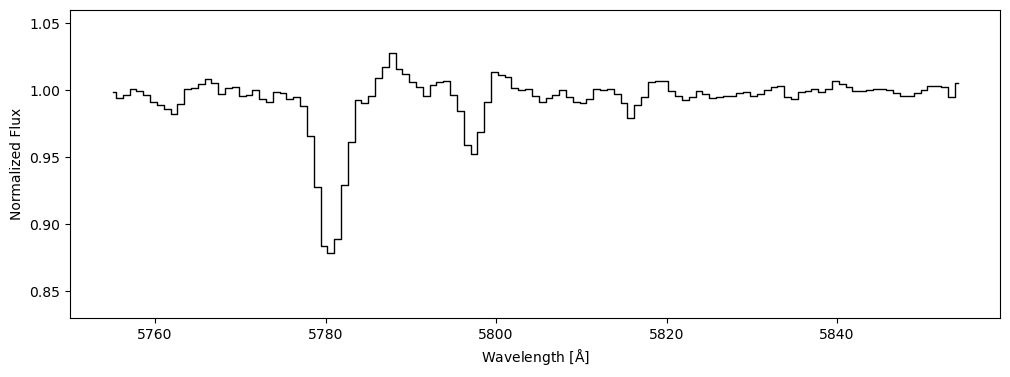

In [6]:
# You can get the CIS by the following `CIS` property (RECOMMENDED)
flux_cis = cis_target.flux_cis
err_flux_cis = cis_target.err_flux_cis

# or you can directly get the CIS by dividing the target spectrum by the template spectrum
# flux_cis = flux_target / flux_template

# Plot the CIS
plt.figure(figsize=(12, 4))
plt.step(dib_region, flux_cis, c='k', lw=1, where='mid')

plt.ylim(0.83, 1.06)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.show()

## Step.4: Measure the DIB 5780 and 5797

/home/maxiaoxiao/LAMOST_DIB/tutorials/../dibkit/core/utils.py:269: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  y = np.abs(np.sqrt(2.0 * np.pi) * u * v)


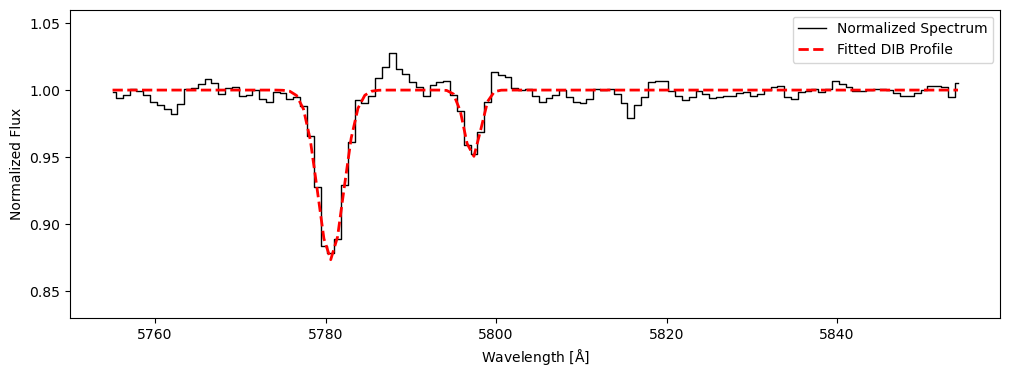

Measurement Result:

threshold: 0.0049
is_5780_detect: 1.0000
is_5797_detect: 1.0000
a0_5780: 0.1215
mu0_5780: 5780.6000
a_5780_sg_cf: 0.1268
aerr_5780_sg_cf: 0.0027
mu_5780_sg_cf: 5780.5856
muerr_5780_sg_cf: 0.0365
sig_5780_sg_cf: 1.5136
sigerr_5780_sg_cf: 0.0365
ew_5780_sg_cf: 0.4810
ewerr_5780_sg_cf: 0.0154
a_5780_sg_mc: 0.1267
aerr_5780_sg_mc: 0.0055
mu_5780_sg_mc: 5780.5835
muerr_5780_sg_mc: 0.0802
sig_5780_sg_mc: 1.5185
sigerr_5780_sg_mc: 0.0774
ew_5780_sg_mc: 0.4821
ewerr_5780_sg_mc: 0.0323
a_5780_sg_cf_simu: 0.1268
aerr_5780_sg_cf_simu: 0.0030
mu_5780_sg_cf_simu: 5780.5857
muerr_5780_sg_cf_simu: 0.0409
sig_5780_sg_cf_simu: 1.5135
sigerr_5780_sg_cf_simu: 0.0409
ew_5780_sg_cf_simu: 0.4810
ewerr_5780_sg_cf_simu: 0.0172
a_5780_sg_mc_simu: 0.1267
aerr_5780_sg_mc_simu: 0.0056
mu_5780_sg_mc_simu: 5780.5834
muerr_5780_sg_mc_simu: 0.0829
sig_5780_sg_mc_simu: 1.5210
sigerr_5780_sg_mc_simu: 0.0809
ew_5780_sg_mc_simu: 0.4829
ewerr_5780_sg_mc_simu: 0.0335
a0_5797: 0.0476
mu0_5797: 5797.4000

In [7]:
# The DIB 5780 and 6614 measurement.
# ! However, this measurement function is highly-encapsulated.
# ! If needed, it is recommended to step into the function `measure_dib5780_lite` to see how it works.
result = measure.measure_dib5780_lite(
    wave=dib_region, 
    flux=flux_cis, 
    flux_err=err_flux_cis,
    snr=target_info['snrr']
)

# Plot the DIB 5780 and 6614 MCMC fitting result
flux_fit = tools_5780.double_gaussian(
    x=dib_region,
    a1=-result['a_5780_sg_mc_simu'],
    b1=result['mu_5780_sg_mc_simu'],
    c1=result['sig_5780_sg_mc_simu'],
    a2=-result['a_5797_sg_mc_simu'],
    b2=result['mu_5797_sg_mc_simu'],
    c2=result['sig_5797_sg_mc_simu'],
)

plt.figure(figsize=(12, 4))
plt.step(dib_region, flux_cis, c='k', lw=1, where='mid', label='Normalized Spectrum')
plt.plot(dib_region, flux_fit, c='r', ls='--', lw=2, label='Fitted DIB Profile')
plt.ylim(0.83, 1.06)
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Normalized Flux')
plt.legend()
plt.show()

# Print the result, which is a dictionary containing the measurement results.
print('Measurement Result:\n')
for key, value in result.items():
    print(f'{key}: {value:.4f}')